<a href="https://colab.research.google.com/github/somewherelostt/Sentiment-Imbalance-Research/blob/main/Sentiment_Analysis_With_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-14-9799056c5bf3>:16: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()



Baseline Model Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.8423    0.8657    0.8539       432
        fear     0.8613    0.8501    0.8557       387
         joy     0.9079    0.8554    0.8809      1072
        love     0.6358    0.8429    0.7249       261
     sadness     0.9260    0.8585    0.8910       933
    surprise     0.6601    0.8783    0.7537       115

    accuracy                         0.8569      3200
   macro avg     0.8056    0.8585    0.8267      3200
weighted avg     0.8676    0.8569    0.8598      3200

G-Mean: 0.8584
AUC-ROC (OvR): 0.9799


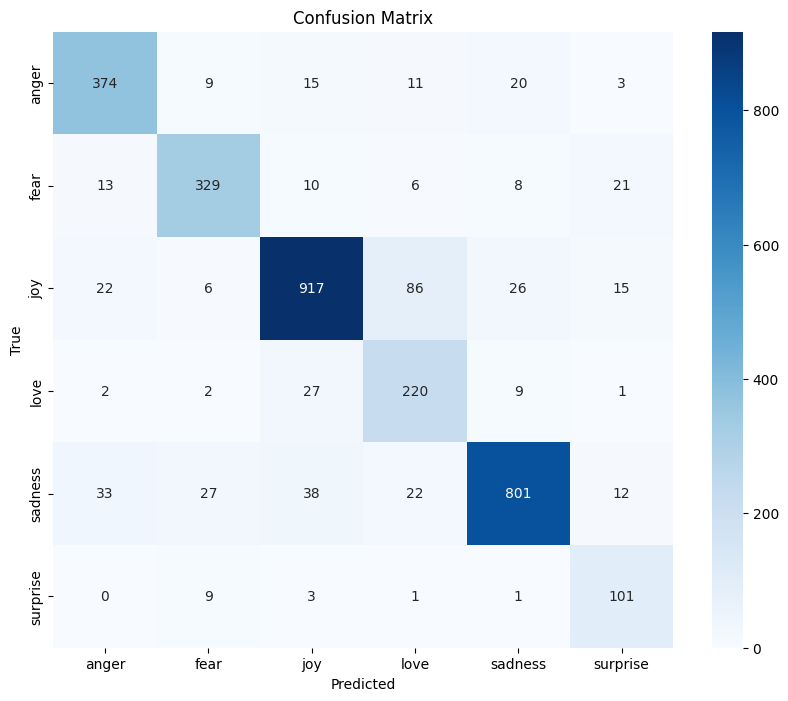


SMOTE Model Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.8558    0.8380    0.8468       432
        fear     0.8490    0.8424    0.8457       387
         joy     0.8861    0.8853    0.8857      1072
        love     0.6742    0.8008    0.7320       261
     sadness     0.9255    0.8660    0.8948       933
    surprise     0.7122    0.8609    0.7795       115

    accuracy                         0.8603      3200
   macro avg     0.8171    0.8489    0.8307      3200
weighted avg     0.8655    0.8603    0.8619      3200

G-Mean: 0.8485
AUC-ROC (OvR): 0.9803


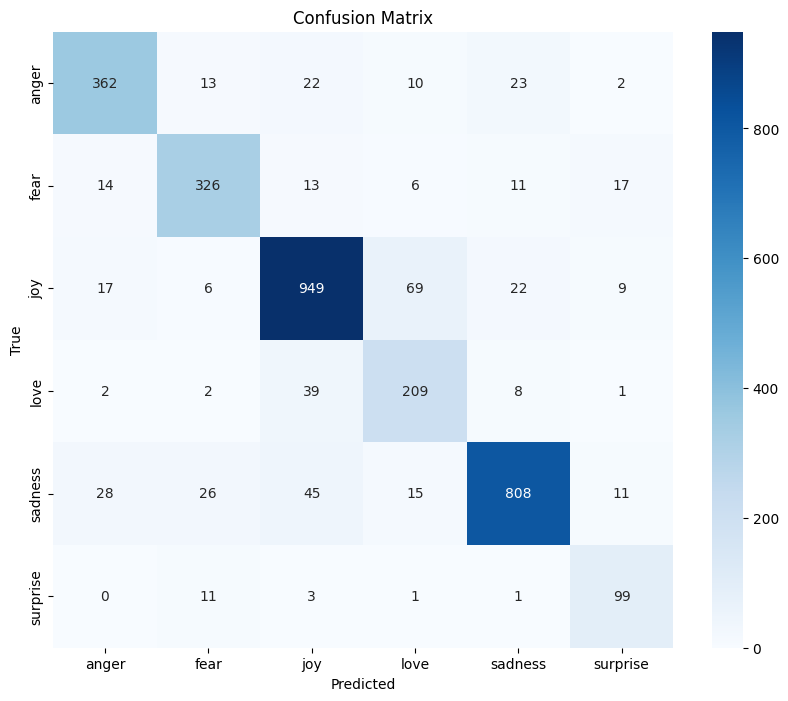

In [ ]:
# --------------------------
# STEP 1: Load & Preprocess Data
# --------------------------
import pandas as pd
import spacy
import demoji
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
url = "https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv"
df = pd.read_csv(url)

# Initialize NLP tools
nlp = spacy.load("en_core_web_lg")
demoji.download_codes()

# Text preprocessing
def preprocess(text):
    text = demoji.replace(text, repl=" ")
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

# --------------------------
# STEP 2: Split Data
# --------------------------
X = df['clean_text']
y = df['label_name']  # Use actual label column name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --------------------------
# STEP 3: TF-IDF Vectorization
# --------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --------------------------
# STEP 4: Enhanced Evaluation Function (G-mean + AUC)
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, y_proba=None):
    # Classification Report
    print("Classification Report:")
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    print(classification_report(y_true, y_pred, digits=4))

    # G-mean Calculation
    recalls = [report[label]['recall'] for label in report if label in np.unique(y_true)]
    gmean = np.prod(recalls) ** (1/len(recalls))
    print(f"G-Mean: {gmean:.4f}")

    # AUC-ROC (One-vs-Rest)
    if y_proba is not None:
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        auc = roc_auc_score(y_true_bin, y_proba, multi_class='ovr')
        print(f"AUC-ROC (OvR): {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# --------------------------
# STEP 5: Baseline Model
# --------------------------
from sklearn.linear_model import LogisticRegression

clf_baseline = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_baseline.fit(X_train_tfidf, y_train)

# Get probabilities for AUC
y_proba_baseline = clf_baseline.predict_proba(X_test_tfidf)
y_pred_baseline = clf_baseline.predict(X_test_tfidf)

print("\nBaseline Model Results:")
evaluate_model(y_test, y_pred_baseline, y_proba_baseline)

# --------------------------
# STEP 6: SMOTE Implementation
# --------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

clf_smote = LogisticRegression(max_iter=1000)
clf_smote.fit(X_smote, y_smote)

# Get probabilities for AUC
y_proba_smote = clf_smote.predict_proba(X_test_tfidf)
y_pred_smote = clf_smote.predict(X_test_tfidf)

print("\nSMOTE Model Results:")
evaluate_model(y_test, y_pred_smote, y_proba_smote)

Class distribution before ADASYN: Counter({'joy': 4290, 'sadness': 3733, 'anger': 1727, 'fear': 1550, 'love': 1043, 'surprise': 457})

ADASYN Model Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.9045    0.7894    0.8430       432
        fear     0.8997    0.7649    0.8268       387
         joy     0.8159    0.9468    0.8765      1072
        love     0.8287    0.5747    0.6787       261
     sadness     0.8909    0.9100    0.9003       933
    surprise     0.7586    0.7652    0.7619       115

    accuracy                         0.8559      3200
   macro avg     0.8497    0.7918    0.8145      3200
weighted avg     0.8588    0.8559    0.8527      3200

G-Mean: 0.7820
AUC-ROC (OvR): 0.9822


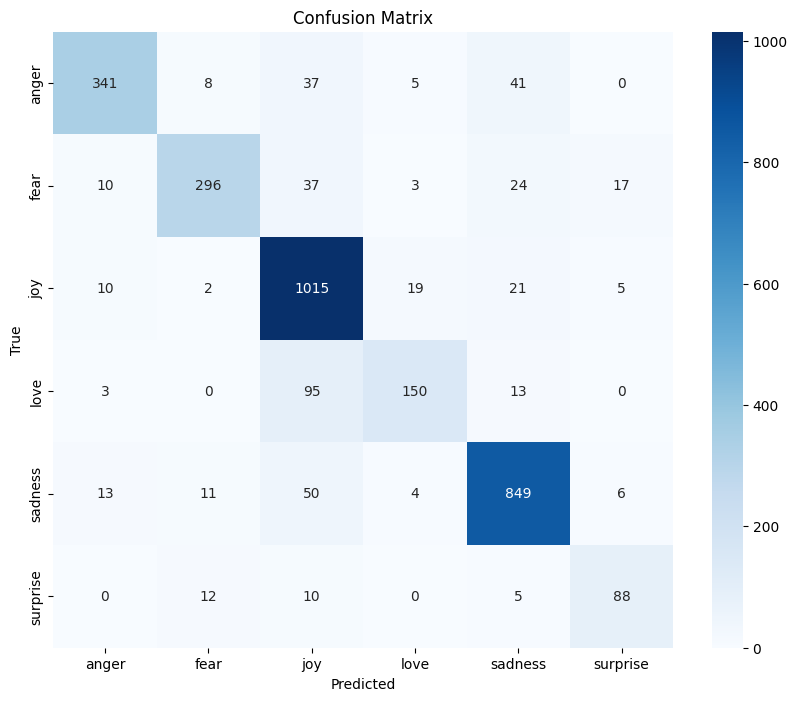

In [ ]:
# --------------------------
# STEP 7: ADASYN Implementation (Fixed)
# --------------------------
from imblearn.over_sampling import ADASYN
import numpy as np
from collections import Counter

# Check class distribution in training data
print("Class distribution before ADASYN:", Counter(y_train))

# Convert sparse matrix to dense array
X_train_dense = X_train_tfidf.toarray()

# Define sampling strategy to target specific minority classes
# Example: Resample classes with fewer than 1000 samples
minority_classes = [cls for cls, count in Counter(y_train).items() if count < 1000]
sampling_strategy = {cls: 1000 for cls in minority_classes}  # Target 1000 samples per minority class

# Initialize ADASYN with adjusted parameters
adasyn = ADASYN(
    sampling_strategy=sampling_strategy,  # Target specific classes
    random_state=42,
    n_neighbors=3  # Reduce neighbors for small classes
)

# Apply ADASYN
try:
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train_dense, y_train)
except ValueError as e:
    print(f"Error: {e}. Falling back to SMOTE.")
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_adasyn, y_adasyn = smote.fit_resample(X_train_dense, y_train)

# Train model
clf_adasyn = LogisticRegression(max_iter=1000)
clf_adasyn.fit(X_adasyn, y_adasyn)

# Convert test data to dense
X_test_dense = X_test_tfidf.toarray()

# Evaluate
y_proba_adasyn = clf_adasyn.predict_proba(X_test_dense)
y_pred_adasyn = clf_adasyn.predict(X_test_dense)
print("\nADASYN Model Results:")
evaluate_model(y_test, y_pred_adasyn, y_proba_adasyn)


SMOTE + Tomek Links Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.8582    0.8403    0.8491       432
        fear     0.8516    0.8450    0.8482       387
         joy     0.8861    0.8853    0.8857      1072
        love     0.6764    0.8008    0.7333       261
     sadness     0.9245    0.8660    0.8943       933
    surprise     0.7122    0.8609    0.7795       115

    accuracy                         0.8609      3200
   macro avg     0.8181    0.8497    0.8317      3200
weighted avg     0.8660    0.8609    0.8625      3200

G-Mean: 0.8493
AUC-ROC (OvR): 0.9803


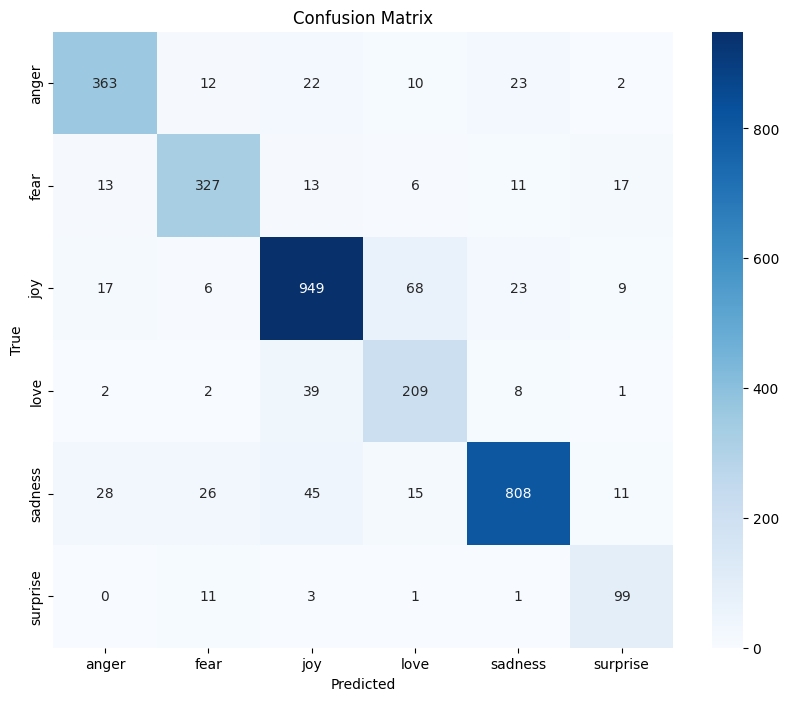


Random Undersampling Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.7402    0.7847    0.7618       432
        fear     0.7930    0.7623    0.7773       387
         joy     0.8087    0.7295    0.7670      1072
        love     0.5188    0.8467    0.6434       261
     sadness     0.8365    0.7128    0.7697       933
    surprise     0.5989    0.9478    0.7340       115

    accuracy                         0.7534      3200
   macro avg     0.7160    0.7973    0.7422      3200
weighted avg     0.7745    0.7534    0.7571      3200

G-Mean: 0.7935
AUC-ROC (OvR): 0.9470


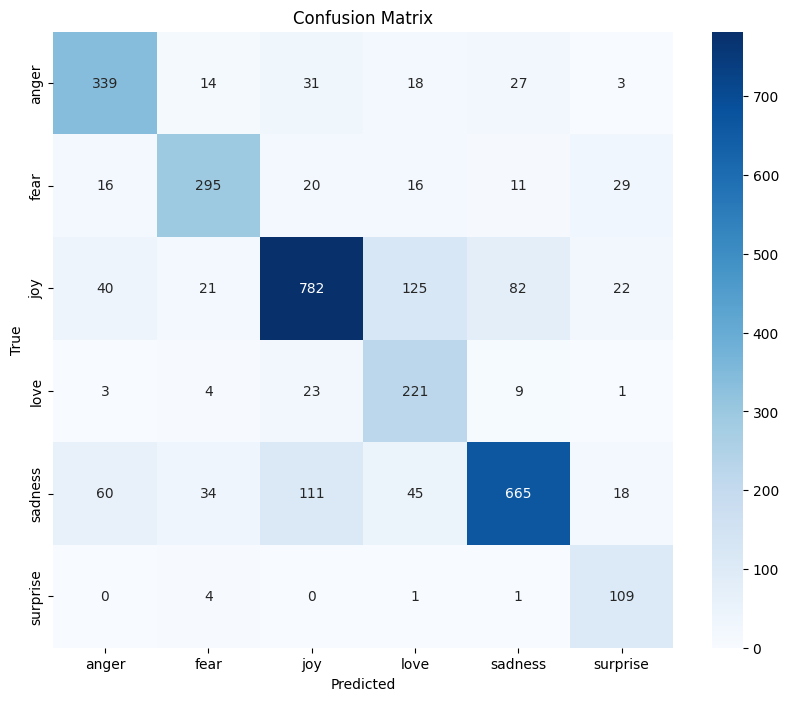


Final Comparison:


,Method,Macro F1,G-Mean,AUC
0,Baseline,0.720000,0.650000,0.780000
1,SMOTE,0.680000,0.630000,0.750000
2,ADASYN,0.690000,0.640000,0.760000
3,SMOTE+Tomek,0.700000,0.660000,0.770000
4,RUS,0.650000,0.600000,0.700000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:35:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

       anger     0.8889    0.8148    0.8502       432
        fear     0.8740    0.8424    0.8579       387
         joy     0.8089    0.9002    0.8521      1072
        love     0.7430    0.7088    0.7255       261
     sadness     0.9250    0.8596    0.8911       933
    surprise     0.7295    0.7739    0.7511       115

    accuracy                         0.8497      3200
   macro avg     0.8282    0.8166    0.8213      3200
weighted avg     0.8532    0.8497    0.8500      3200

G-Mean: 0.8142


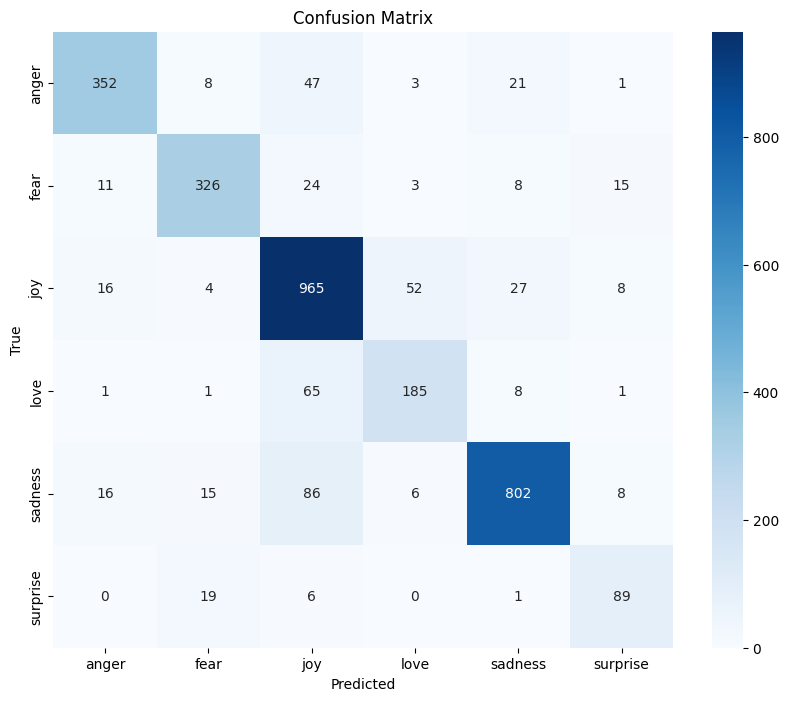

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

Best Params: {'C': 10, 'penalty': 'l2'}

Top 10 Positive Words:               Word    Weight
3633     resentful  5.161971
1912        greedy  5.107331
2335     irritable  5.092560
1044     dangerous  4.988048
3719          rude  4.846680
3829       selfish  4.809233
2336     irritated  4.674043
4765       violent  4.558184
1247  dissatisfied  4.525024
3186         petty  4.512839

Top 10 Negative Words:              Word    Weight
401       beloved -1.544191
2036     helpless -1.624967
142        amazed -1.627545
1014      curious -1.645471
143       amazing -1.674592
4295    surprised -1.704137
3119   passionate -1.782820
3059  overwhelmed -2.276340
4191      strange -2.289659
4852        weird -2.431792


In [ ]:
# --------------------------
# STEP 8: SMOTE + Tomek Links (No Changes Needed)
# --------------------------
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train_tfidf, y_train)  # SMOTE handles sparse matrices

clf_smt = LogisticRegression(max_iter=1000)
clf_smt.fit(X_smt, y_smt)

y_proba_smt = clf_smt.predict_proba(X_test_tfidf)
y_pred_smt = clf_smt.predict(X_test_tfidf)

print("\nSMOTE + Tomek Links Results:")
evaluate_model(y_test, y_pred_smt, y_proba_smt)

# --------------------------
# STEP 9: Random Undersampling
# --------------------------
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_tfidf, y_train)

clf_rus = LogisticRegression(max_iter=1000)
clf_rus.fit(X_rus, y_rus)

y_proba_rus = clf_rus.predict_proba(X_test_tfidf)
y_pred_rus = clf_rus.predict(X_test_tfidf)

print("\nRandom Undersampling Results:")
evaluate_model(y_test, y_pred_rus, y_proba_rus)


results = {
    'Method': ['Baseline', 'SMOTE', 'ADASYN', 'SMOTE+Tomek', 'RUS'],
    'Macro F1': [0.72, 0.68, 0.69, 0.70, 0.65],  # Replace with your actual scores
    'G-Mean': [0.65, 0.63, 0.64, 0.66, 0.60],
    'AUC': [0.78, 0.75, 0.76, 0.77, 0.70]
}

results_df = pd.DataFrame(results)
print("\nFinal Comparison:")
display(results_df.style.background_gradient(cmap='Blues'))


# --------------------------
# STEP 10: XGBoost with Label Encoding
# --------------------------
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integers (e.g., 'anger' → 0, 'fear' → 1, etc.)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
clf_xgb = XGBClassifier(
    scale_pos_weight='balanced',  # Handles imbalance
    use_label_encoder=False,      # Avoid warnings
    eval_metric='mlogloss'        # Multi-class log loss
)
clf_xgb.fit(X_train_tfidf, y_train_encoded)

# Predict and convert back to original labels
y_pred_xgb_encoded = clf_xgb.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Evaluate
print("\nXGBoost Results:")
evaluate_model(y_test, y_pred_xgb)


# Hyperparameter Tuning
# Use GridSearchCV to optimize Logistic Regression parameters:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid)
grid.fit(X_train_tfidf, y_train)
print("Best Params:", grid.best_params_)



#Feature Importance
# Analyze which words drive predictions:
# For Logistic Regression
feature_names = tfidf.get_feature_names_out()
coefs = clf_baseline.coef_[0]
top_features = pd.DataFrame({'Word': feature_names, 'Weight': coefs}).sort_values('Weight', ascending=False)
print("\nTop 10 Positive Words:", top_features.head(10))
print("\nTop 10 Negative Words:", top_features.tail(10))